In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils as ut

In [17]:
profiles_flattened, surveys = ut.load_data()

file profiles\profil_20190212.pkl contains 29 profiles, average length is 2265.83, std is 647.52
file profiles\profil_20190327.pkl contains 1 profiles, average length is 2832.00, std is 0.00
file profiles\profil_20200210.pkl contains 37 profiles, average length is 2866.70, std is 403.25
file profiles\profil_20200229.pkl contains 40 profiles, average length is 2317.03, std is 572.10
file profiles\profil_20200301.pkl contains 34 profiles, average length is 2098.74, std is 319.74
file profiles\profil_20220119.pkl contains 53 profiles, average length is 2436.04, std is 34.11
file profiles\profil_20220124.pkl contains 54 profiles, average length is 2416.70, std is 34.97
file profiles\profil_20220127.pkl contains 63 profiles, average length is 2139.13, std is 293.77
file profiles\profil_20220225.pkl contains 50 profiles, average length is 2445.74, std is 669.22


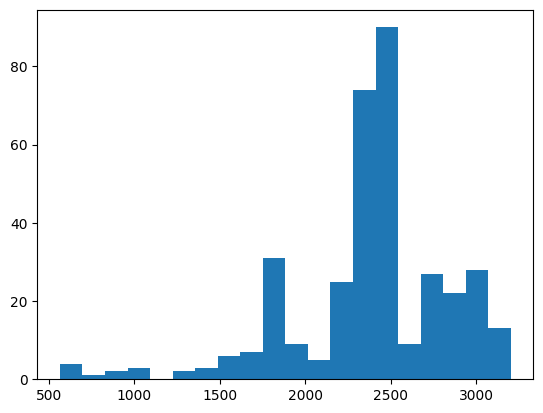

In [117]:
for survey, profiles in surveys.items():
    lengths = []
    for profile in profiles.values():
        lengths.append(len(profile))

    print(f'file {survey} contains {len(profiles)} profiles, average length is {np.mean(lengths):.2f}, std is {np.std(lengths):.2f}')

lengths = []
for profile in profiles_flattened.values():
    lengths.append(len(profile))
    
_ = plt.hist(lengths, 20)

In [144]:
survey['SMP_1119']

,distance,force_median,fmax,L2012_lambda,L2012_f0,L2012_delta,L2012_L,npeaks,B2009_psi,gradient_psi,delta_bellaire,delta_bellairef5,layer
0,0.0,0.077579,0.271846,73.882425,0.065352,0.039100,0.642929,47.501143,0.158102,0.203409,0.000000,0.000000,S1
1,0.5,0.141052,0.718083,28.965607,0.200484,0.063281,0.878447,25.444762,0.259806,0.240035,0.011603,0.000000,S1
2,1.0,0.302621,0.848876,122.134759,0.117713,0.045341,0.543747,66.410408,0.398137,0.186418,0.021560,0.000000,S1
3,1.5,0.390457,1.034808,150.407933,0.114831,0.049819,0.507286,76.299869,0.446224,0.020014,0.003488,0.000000,S1
4,2.0,0.601394,1.034808,164.729226,0.101276,0.069640,0.492137,81.069420,0.418151,0.156313,0.041945,0.000000,S1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,743.5,0.262870,0.420591,792.840962,0.022387,0.028779,0.291484,231.100393,0.263488,-0.013633,-4.351649,-4.351649,WL
1488,744.0,0.208372,0.382123,329.409748,0.035373,0.036187,0.390629,128.677000,0.231814,0.103172,36.118855,36.118855,B
1489,744.5,0.180162,1.086100,201.585955,0.077620,0.024431,0.460105,92.750618,0.366659,2.662162,326.743609,0.000000,B
1490,745.0,1.194453,11.352116,7.426143,5.533577,0.173740,1.382788,10.268780,2.893976,4.004852,46.861444,0.000000,B


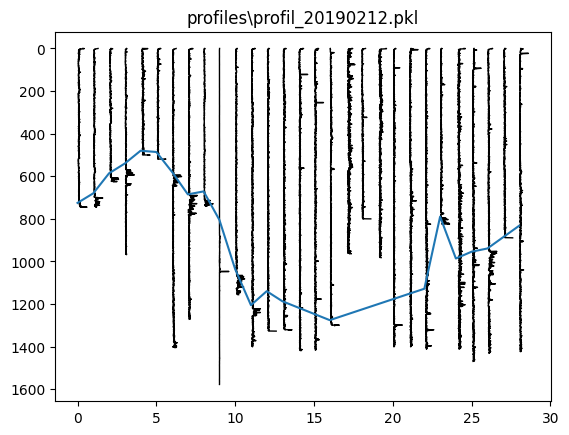

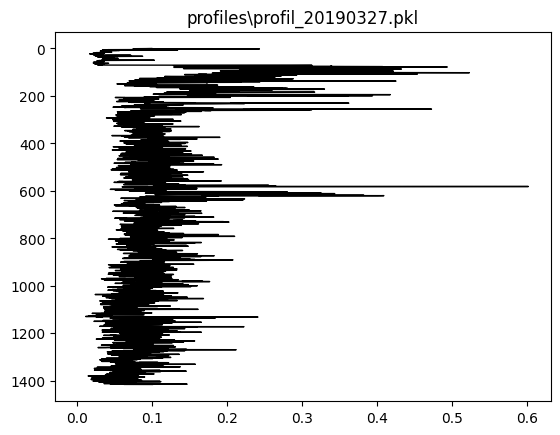

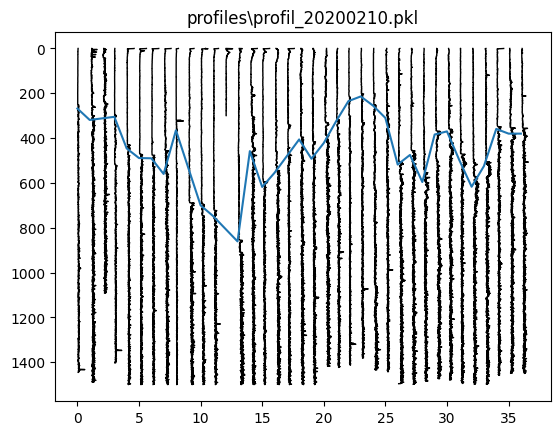

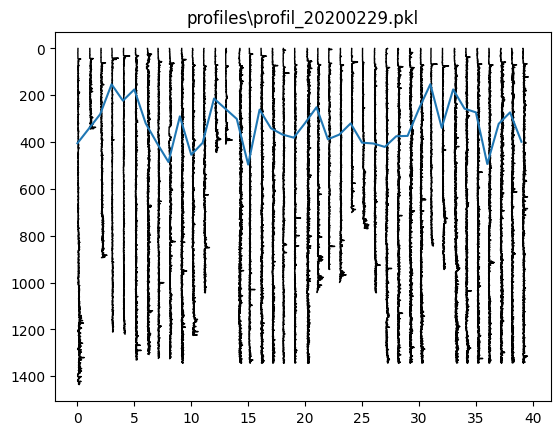

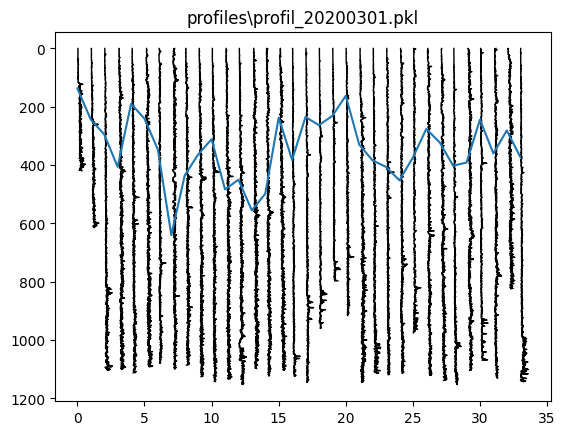

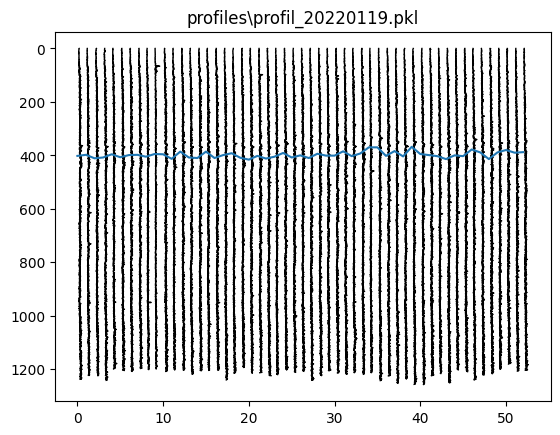

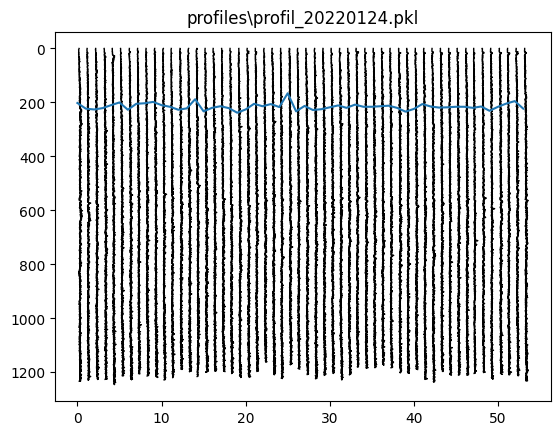

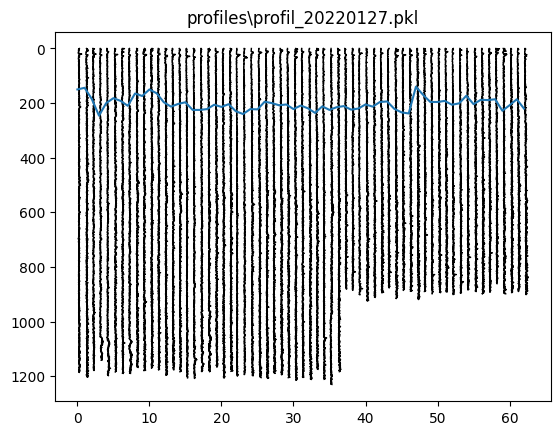

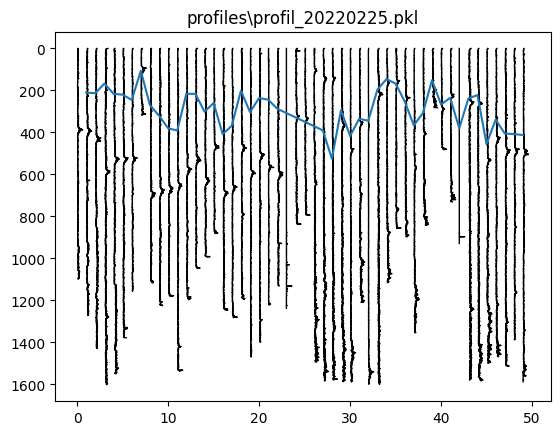

In [156]:
def plot_survey(survey, feature='force_median'):
    fig, ax = plt.subplots()

    isweak = []
    for i, (key, profile) in enumerate(survey.items()):
        plt.plot(i + 2 * np.log10(profile[feature]/profile[feature].max() + 1), profile['distance'], c='k', lw=1)
        try:
            isweak.append((i, profile['distance'].loc[profile['layer'] == 'WL'].iloc[0]))
        except Exception:
            pass

    ax.plot(*np.array(isweak).T)
    ax.invert_yaxis()
    return fig, ax

for key, survey in surveys.items():
    fig, ax = plot_survey(survey, feature='L2012_L')
    ax.set_title(key)

we will build a simple train/val/test data set where we will gather profiles from similar surveys in a training/validation manner while omitting some surveys completely.

Let's import some dummy functions made by ChatGPT to build a simple CNN

In [ ]:
class UNet1D(nn.Module):
    def __init__(self, input_channels, output_channels, features=(64, 128, 256, 512)):
        super(UNet1D, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Encoder: Down-sampling
        for feature in features:
            self.encoder.append(
                nn.Sequential(
                    nn.Conv1d(input_channels, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv1d(feature, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                )
            )
            input_channels = feature

        # Decoder: Up-sampling
        for feature in reversed(features):
            self.decoder.append(
                nn.Sequential(
                    nn.Conv1d(2 * feature, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv1d(feature, feature, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                )
            )
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.upsample = nn.ConvTranspose1d(feature, feature // 2, kernel_size=2, stride=2)

        # Final output layer
        self.final_layer = nn.Conv1d(features[0], output_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)

        skip_connections = skip_connections[::-1]

        # Decoder
        for idx, layer in enumerate(self.decoder):
            x = self.upsample(x)
            if x.size(-1) != skip_connections[idx].size(-1):
                x = F.pad(x, (0, skip_connections[idx].size(-1) - x.size(-1)))
            x = torch.cat((skip_connections[idx], x), dim=1)
            x = layer(x)

        # Final output
        return self.final_layer(x)

In [80]:
train_profiles = {}
for key in list(surveys.keys())[:1]:
    train_profiles = {**train_profiles, **surveys[key]}
    
print(len(train_profiles))

29


In [ ]:
profiles, labels = prepare_data(train_profiles)
dataset = SequenceDataset(profiles, labels)
dataloaer = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: (
    torchd.nn.utils.rnn.pad_sequence([torch.tensor(p[0]) for p in x], batch_first=True),
    torch.nn.utils.rnn.pad_sequence([torch.tensor(p[1]) for p in x], batch_first=True, padding_value=-1)
))

input_dim = np.shape(profiles[0])[-1]
num_classes = 2

#model = TransformerModel(input_dim, num_classes)
criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore padding in labels
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, dataloader, criterion, optimizer)

6/6, loss: 0.069
epoch 1/1000, average loss: 0.100
6/6, loss: 0.086
epoch 2/1000, average loss: 0.101
6/6, loss: 0.059
epoch 3/1000, average loss: 0.097
6/6, loss: 0.124
epoch 4/1000, average loss: 0.103
6/6, loss: 0.066
epoch 5/1000, average loss: 0.098
6/6, loss: 0.061
epoch 6/1000, average loss: 0.096
6/6, loss: 0.031
epoch 7/1000, average loss: 0.095
6/6, loss: 0.152
epoch 8/1000, average loss: 0.109
6/6, loss: 0.184
epoch 9/1000, average loss: 0.111
6/6, loss: 0.079
epoch 10/1000, average loss: 0.098
6/6, loss: 0.149
epoch 11/1000, average loss: 0.107
6/6, loss: 0.116
epoch 12/1000, average loss: 0.102
6/6, loss: 0.064
epoch 13/1000, average loss: 0.096
6/6, loss: 0.105
epoch 14/1000, average loss: 0.102
6/6, loss: 0.066
epoch 15/1000, average loss: 0.097
6/6, loss: 0.056
epoch 16/1000, average loss: 0.096
6/6, loss: 0.105
epoch 17/1000, average loss: 0.101
6/6, loss: 0.131
epoch 18/1000, average loss: 0.104
6/6, loss: 0.132
epoch 19/1000, average loss: 0.107
6/6, loss: 0.072
epoc

KeyboardInterrupt: 

In [90]:
tmp = torch.tensor(dataset[2][0]).float()
tmp = tmp.reshape(1, *tmp.shape)
out = model.forward(tmp)

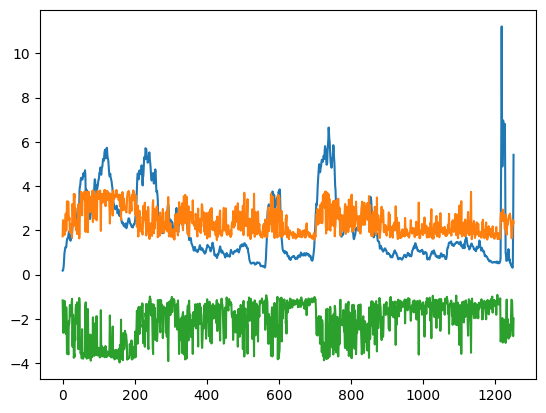

In [91]:
plt.plot(tmp[0][:, 0])
plt.plot(out[0].detach())